# Very quick machine learning

This notebook goes with 
We're going to go over a very simple machine learning exercise. We're using the data from the [2016 SEG machine learning contest](https://github.com/seg/2016-ml-contest). This exercise previously appeared as [an Agile blog post](http://ageo.co/xlines04).

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

## Read the data

[Pandas](http://pandas.pydata.org/) is really convenient for this sort of data.

In [2]:
import pandas as pd

uid = "1WZsd3AqH9dEOOabZNjlu1M-a8RlzTyu9BYc2cw8g6J8"
uri = f"https://docs.google.com/spreadsheets/d/{uid}/export?format=csv"
df = pd.read_csv(uri)

df.head()

,Facies Code,Formation,Well Name,Depth,GR,ILD,DeltaPHI,PHIND,PE
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,21.281390,9.9,11.915,4.6
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,20.989399,14.2,12.565,4.1
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,20.701413,14.8,13.050,3.6
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,20.417379,13.9,13.115,3.5
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,19.678863,13.5,13.300,3.4


<div style="margin-top:12px; padding: 12px; border:2px solid gray; border-radius:5px; background: #eeeeee;"><p><b>A word about the data.</b> This dataset is not, strictly speaking, open data. It has been shared by the Kansas Geological Survey for the purposes of the contest. That's why I'm not copying the data into this repository, but instead reading it from the web. We are working on making an open access version of this dataset. In the meantime, I'd appreciarte it if you didn't replicate the data anywhere. Thanks!</p></div>

## Inspect the data

First, we need to see what we have.

In [3]:
df.describe()

,Facies Code,Depth,GR,ILD,DeltaPHI,PHIND,PE
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,35.890418,3.559642,13.483213,3.725014
std,2.504243,131.006274,30.854826,55.469745,5.228948,7.698980,0.896152
min,1.000000,2573.500000,13.250000,0.887364,-21.832000,0.550000,0.200000
25%,2.000000,2791.000000,46.918750,9.671656,1.163750,8.346750,3.100000
50%,4.000000,2893.500000,65.721500,17.736735,3.500000,12.150000,3.551500
75%,6.000000,2980.000000,79.626250,42.215227,6.432500,16.453750,4.300000
max,9.000000,3122.500000,361.150000,912.010839,18.600000,84.400000,8.094000


In [4]:
facies_dict = {1:'sandstone', 2:'c_siltstone', 3:'f_siltstone', 4:'marine_silt_shale',
               5:'mudstone', 6:'wackestone', 7:'dolomite', 8:'packstone', 9:'bafflestone'}

df["Facies"] = df["Facies Code"].replace(facies_dict)

In [5]:
df.groupby('Facies').count()

,Facies Code,Formation,Well Name,Depth,GR,ILD,DeltaPHI,PHIND,PE
Facies,,,,,,,,,
bafflestone,161,161,161,161,161,161,161,161,161
c_siltstone,738,738,738,738,738,738,738,738,738
dolomite,98,98,98,98,98,98,98,98,98
f_siltstone,615,615,615,615,615,615,615,615,615
marine_silt_shale,184,184,184,184,184,184,184,184,184
mudstone,217,217,217,217,217,217,217,217,217
packstone,498,498,498,498,498,498,498,498,498
sandstone,259,259,259,259,259,259,259,259,259
wackestone,462,462,462,462,462,462,462,462,462


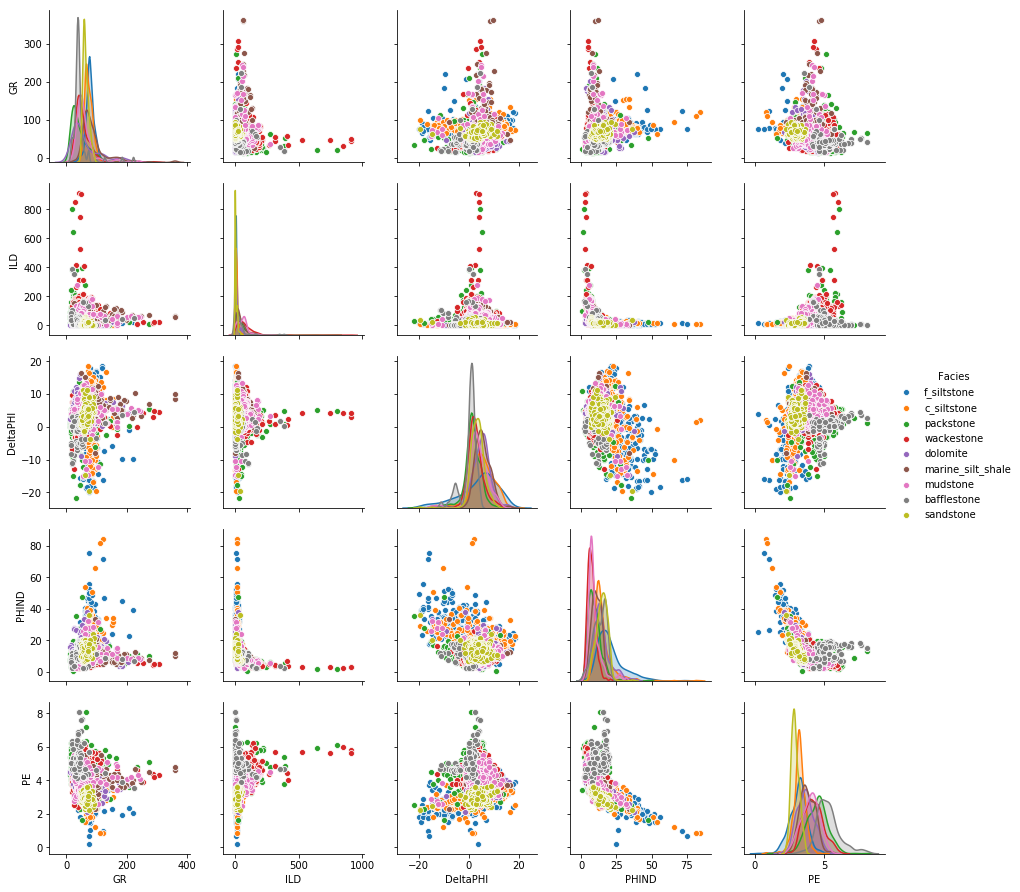

In [7]:
features = ['GR', 'ILD', 'DeltaPHI', 'PHIND', 'PE']

sns.pairplot(df, vars=features, hue='Facies')

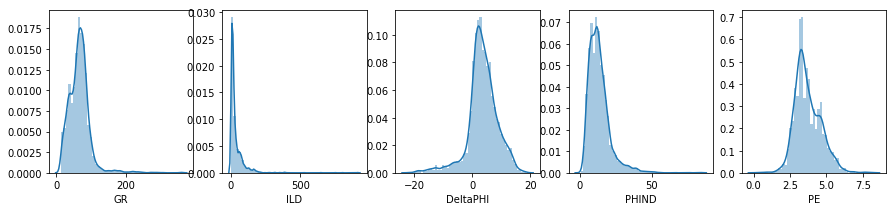

In [8]:
fig, axs = plt.subplots(ncols=5, figsize=(15, 3))

for ax, feature in zip(axs, features):
    sns.distplot(df[feature], ax=ax)

## Label and feature engineering

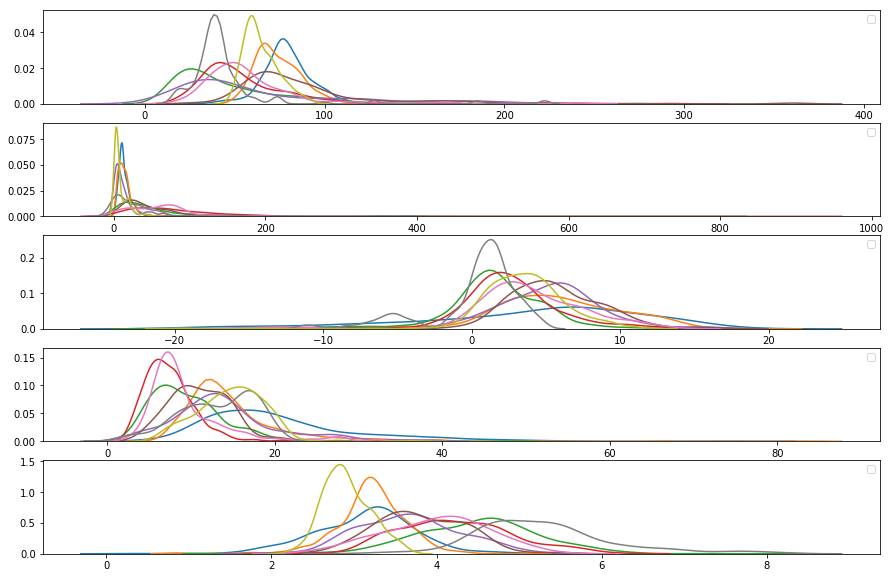

In [9]:
fig, axs = plt.subplots(nrows=5, figsize=(15, 10))

for ax, feature in zip(axs, features):
    for facies in df.Facies.unique():
        sns.kdeplot(df.loc[df.Facies==facies][feature], ax=ax, label=facies)
        ax.legend('')

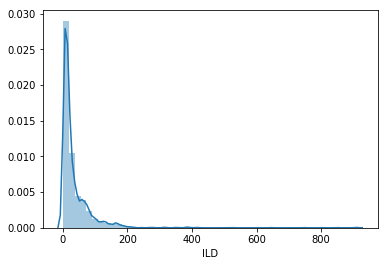

In [10]:
sns.distplot(df.ILD)

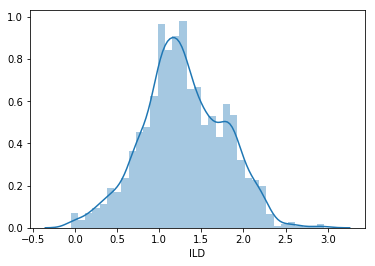

In [11]:
sns.distplot(np.log10(df.ILD))

In [12]:
df['log_ILD'] = np.log10(df.ILD)

## Get the feature vectors, `X`

In [13]:
features = ['GR', 'log_ILD', 'DeltaPHI', 'PHIND', 'PE']

Now we'll load the data we want. First the feature vectors, `X`. We'll just get the logs, which are in columns 4 to 8:

In [14]:
X = df[features].values

In [15]:
X.shape

(3232, 5)

In [16]:
X

array([[77.45 ,  1.328,  9.9  , 11.915,  4.6  ],
       [78.26 ,  1.322, 14.2  , 12.565,  4.1  ],
       [79.05 ,  1.316, 14.8  , 13.05 ,  3.6  ],
       ...,
       [49.719,  1.928,  2.925,  8.013,  3.19 ],
       [51.469,  1.93 ,  3.083,  7.708,  3.152],
       [50.031,  1.94 ,  2.609,  6.668,  3.295]])

## Get the label vector, `y`

In [18]:
y = df.Facies.values

In [19]:
y

array(['f_siltstone', 'f_siltstone', 'f_siltstone', ..., 'mudstone',
       'mudstone', 'mudstone'], dtype=object)

In [20]:
y.shape

(3232,)

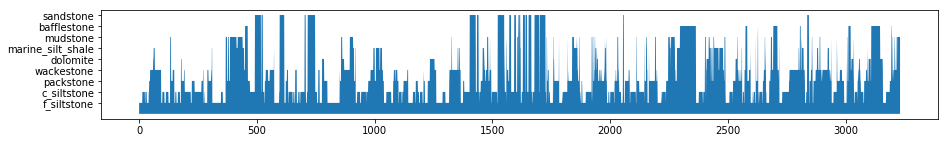

In [21]:
plt.figure(figsize=(15,2))
plt.fill_between(np.arange(y.size), y, -1)

We have data! Almost ready to train, we just have to get our test / train subsets sorted.

## Extracting some training data

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y)

In [23]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2424, 5), (2424,), (808, 5), (808,))

**Optional exercise:** Use [the docs for `train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to set the size of the test set, and also to set a random seed for the splitting.

Now the fun can really begin. 

## Training

In [25]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

## Predict and evaulate

In [26]:
y_pred = clf.predict(X_val)

How did we do? A quick score:

In [27]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred)

0.49876237623762376

A better score:

In [28]:
from sklearn.metrics import f1_score

f1_score(y_val, y_pred, average='weighted')

0.49237581934427793

We can also get a quick score, without using `predict`, but it's not always clear what this score represents. 

In [ ]:
clf.score(X_val, y_val)

## Model tuning and model selection

**Optional exercise:** Let's change the hyperparameters of the model. E.g. try changing the `n_neighbours` argument.

In [ ]:
clf = KNeighborsClassifier(... HYPERPARAMETERS GO HERE ...)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

**Optional exercise:** Try another classifier.

In [ ]:
from sklearn.svm import SVC

clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

**Optional exercise:** Let's look at another classifier. Try changing some hyperparameters, eg `verbose`, `n_estimators`, `n_jobs`, and `random_state`.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier 

clf = ExtraTreesClassifier(n_estimators=100)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

All models have the same API (but not the same hyperparameters), so it's very easy to try lots of models.

## More in-depth evaluation

The confusion matrix, showing exactly what kinds of mistakes (type 1 and type 2 errors) we're making:

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

Finally, the classification report shows the type 1 and type 2 error rates (well, 1 - the error) for each facies, along with the combined, F1, score:

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

<html><hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2019</p>
</div></html>